In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from pyscipopt import Model
import time

In [2]:
class box:
    def __init__(self,dim):
        self.dimensioni=dim

    def getW(self):
        return self.dimensioni[0]

    def getD(self):
        return self.dimensioni[1]


In [3]:
class cargo:
    def __init__(self,dim):
        self.dimensioni=dim

    def getW(self):
        return self.dimensioni[0]

    def getD(self):
        return self.dimensioni[1]



In [4]:
def plotSolution(solution, camion, packages):
    boxes = []

    width = [p.dimensioni[0] for p in packages]
    depth = [p.dimensioni[1] for p in packages]
    
    #bin
    container = Rectangle((0,0), camion.dimensioni[1], camion.dimensioni[0], facecolor='white')
    boxes.append(container)

    #items
    for a in solution:
        w = width[a[2]] if a[3] is 0 else depth[a[2]]
        d = depth[a[2]] if a[3] is 0 else width[a[2]]
        box = Rectangle((a[1],a[0]), d, w, facecolor='r')
        boxes.append(box)

    #plot
    facecolors = [b.get_facecolor() for b in boxes]

    collection = PatchCollection(boxes, facecolor=facecolors, alpha=0.4, edgecolor='black', linewidths=2)

    ax = plt.gca(xlabel='depth',ylabel='width')
    ax.add_collection(collection)
    ax.autoscale_view()
    ax.axis('equal')
    plt.draw_if_interactive()

In [5]:
def model(packages,cargo):
    model = Model("Model2D")  
    # importo dimensioni dei pacchi e del camion
    n=len(packages)

    w =[packages[i].getW() for i in range(n)]
    d =[packages[i].getD() for i in range(n)]

    print(w)
    print(d)

    W =cargo.getW()
    D =model.addVar(vtype="INTEGER",name="D")

    Md=sum(d)
    Mw=W+min(w)

    # definisco le variabili
    s1 =[[model.addVar(vtype="B",name ="s1%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    s2 =[[model.addVar(vtype="B",name ="s2%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    s3 =[[model.addVar(vtype="B",name ="s3%d%d" % (i,j)) for i in range(n)] for j in range(n)]
    s4 =[[model.addVar(vtype="B",name ="s4%d%d" % (i,j)) for i in range(n)] for j in range(n)]

    x =[model.addVar(vtype="INTEGER",name="x%d" % i) for i in range(n)]
    y =[model.addVar(vtype="INTEGER",name="y%d" % i) for i in range(n)]

    # definisco i constraints
    for i in range(n):
        for j in range(n):
            if(i < j):
                model.addCons(x[i] + w[i] <= x[j] + Mw*(1-s1[i][j]))           #(1)
                model.addCons(y[i] + d[i] <= y[j] + Md*(1-s2[i][j]))           #(2)
                model.addCons(x[j] + w[j] <= x[i] + Mw*(1-s3[i][j]))           #(3)
                model.addCons(y[j] + d[j] <= y[i] + Md*(1-s4[i][j]))           #(4)
                model.addCons(s1[i][j]+s2[i][j]+s3[i][j]+s4[i][j]>=1)          #(5)
        model.addCons(x[i] + w[i]<= W)                                         #(6)
        model.addCons(y[i] + d[i]<= D)                                         #(7)

    #funzione obiettivo
    model.setObjective(D, "minimize")
    model.data=x,y,s1,s2,s3,s4,w,d,W,D
    return model


In [6]:
def main():
    packages =[]
    for i in range(0,5):
        w=120
        d=80
        packages.append(box([w,d]))
    camion =cargo([250,1350])
    t=time.time()
    models =model(packages,camion)
    models.optimize()
    x,y,s1,s2,s3,s4,w,d,W,D= models.data
    s = []
    for i in range(len(packages)):
        s.append([models.getVal(x[i]), models.getVal(y[i]), i, 0])
    plotSolution(s, camion, packages)
    print s

[120, 120, 120, 120, 120]
[80, 80, 80, 80, 80]
[[120.0, 80.0, 0, 0], [120.0, 0.0, 1, 0], [0.0, 80.0, 2, 0], [0.0, 0.0, 3, 0], [130.0, 160.0, 4, 0]]


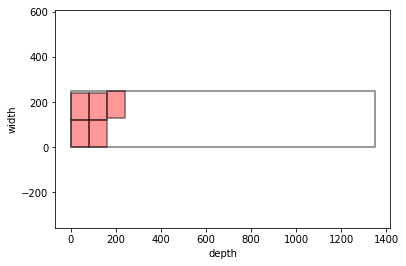

In [7]:
main()